In [37]:
from gpt.utils import set_seed, setup_logging, CfgNode as CN
from gpt.model import GPT
import os
import matplotlib.pyplot as plt
import torch
from gpt.dataset import NewPairedData
import numpy as np

def get_config():

    C = CN()

    # system
    C.system = CN()
    C.system.seed = 3407
    C.system.work_dir = './out/jul9_fix_oldg4params'

    # model
    C.model = GPT.get_default_config()
    C.model.model_type = 'gpt-mini'

    return C


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device is {device}')

config = get_config()
print(config)
test_dataset = NewPairedData(train=False)
config.model.block_size = test_dataset.get_block_size()
config.model.scores_size = test_dataset.get_scores_length()
config.model.far_reco_size = test_dataset.get_far_reco_length()


model = GPT(config.model)
model.load_state_dict(torch.load(os.path.join(config.system.work_dir, 'model.pt')))
model = model.eval()

Device is cuda
system:
    seed: 3407
    work_dir: ./out/jul9_fix_oldg4params
model:
    model_type: gpt-mini
    n_layer: None
    n_head: None
    n_embd: None
    n_gaussians: 42
    vocab_size: None
    block_size: None
    scores_size: None
    far_reco_size: None
    embd_pdrop: 0.0
    resid_pdrop: 0.1
    attn_pdrop: 0.1

number of parameters: 2.67M


In [24]:
len(test_dataset.near_reco), len(test_dataset.far_reco), len(test_dataset.cvn_scores)

(16, 3, 1)

In [25]:
import pandas as pd
true_df = pd.read_csv('data/ndfd_reco_only_cuts.noFDhasel_oldg4params.csv')

In [31]:
test_dataset = NewPairedData(train=False)

import pandas as pd
import seaborn as sns

def get_df(pred_x, true_x=None):
    col_names = test_dataset.near_reco + test_dataset.cvn_scores + test_dataset.far_reco 
    assert len(col_names) == pred_x.shape[1]
    df = pd.DataFrame(pred_x, columns=col_names)
    df['class'] = 'predicted'
    df_true = pd.DataFrame(true_x, columns=col_names)

    if true_x is not None: 
        assert len(col_names) == true_x.shape[1]
        df_true['class'] = 'true'
        df = pd.concat([df, df_true])
    return df

In [38]:
batch_size = 2000
num_iter = 90
model = model.to(device)

# shuffle it 
test_dataset.data = test_dataset.data[np.random.permutation(len(test_dataset.data))]
pred_list = []
for i in range(num_iter):
    idx = torch.tensor(test_dataset.data[:, :len(test_dataset.near_reco)], dtype=torch.float).to(device)[i*batch_size:(i+1)*batch_size]
    pred = model.generate(idx, device='cuda').cpu().numpy()
    pred_list.append(pred)
pred = np.concatenate(pred_list)

df = get_df(pred, test_dataset.data[:len(pred), :])

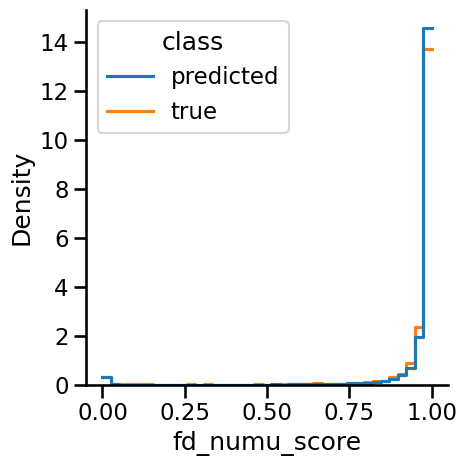

In [33]:
# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_context('talk')
bins = np.linspace(0.0, 1.0, 40)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
common_kwargs = dict(hue='class', stat='density', element='step', common_norm=True, bins=bins, fill=False, log_scale=True)
sns.histplot(data=df, x='fd_numu_score', hue='class', stat='density', element='step', common_norm=True, bins=bins, ax=ax, fill=False, legend=True)
sns.despine()
plt.tight_layout()

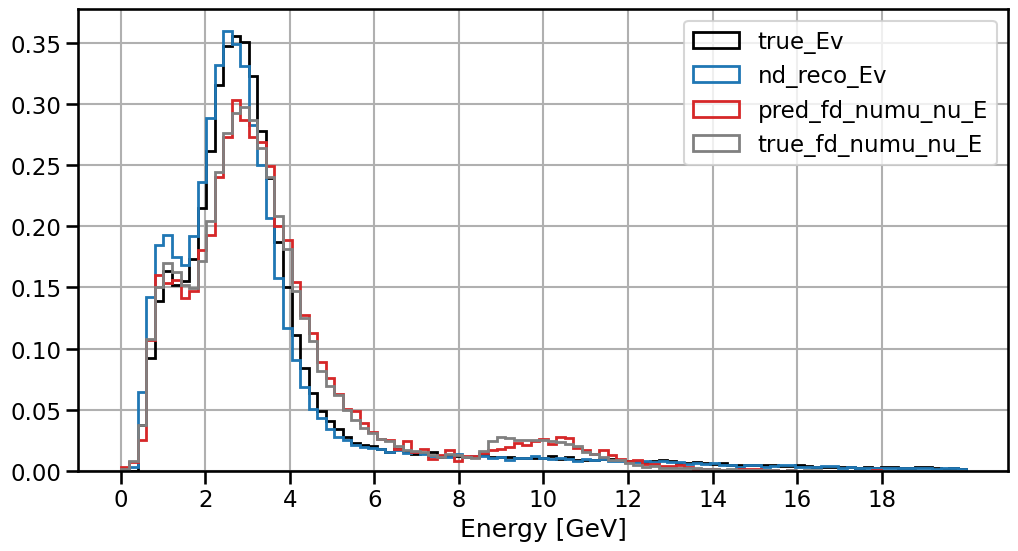

In [34]:
nu_true = true_df['Ev']
nu_nd_reco = true_df['Ev_reco']
fd_numu_nuE_true = true_df['fd_numu_nu_E']
pred_numu_nuE = df['fd_numu_nu_E'][df['class'] == 'predicted']

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
bins = np.linspace(0, 20, 100)
common_kwargs = dict(bins=bins, density=True, histtype='step', lw=2.0)
ax.hist(nu_true, label='true_Ev', **common_kwargs, color='black')
ax.hist(nu_nd_reco, label='nd_reco_Ev', **common_kwargs, linestyle='-', color='tab:blue')
ax.hist(pred_numu_nuE, label='pred_fd_numu_nu_E', **common_kwargs, color='tab:red')
ax.hist(fd_numu_nuE_true, label='true_fd_numu_nu_E', **common_kwargs, color='gray', alpha=1.0)

ax.legend()
ax.set_xlabel('Energy [GeV]')
# ticks at ever 2 GeV
ax.set_xticks(np.arange(0, 20, 2))
plt.grid()

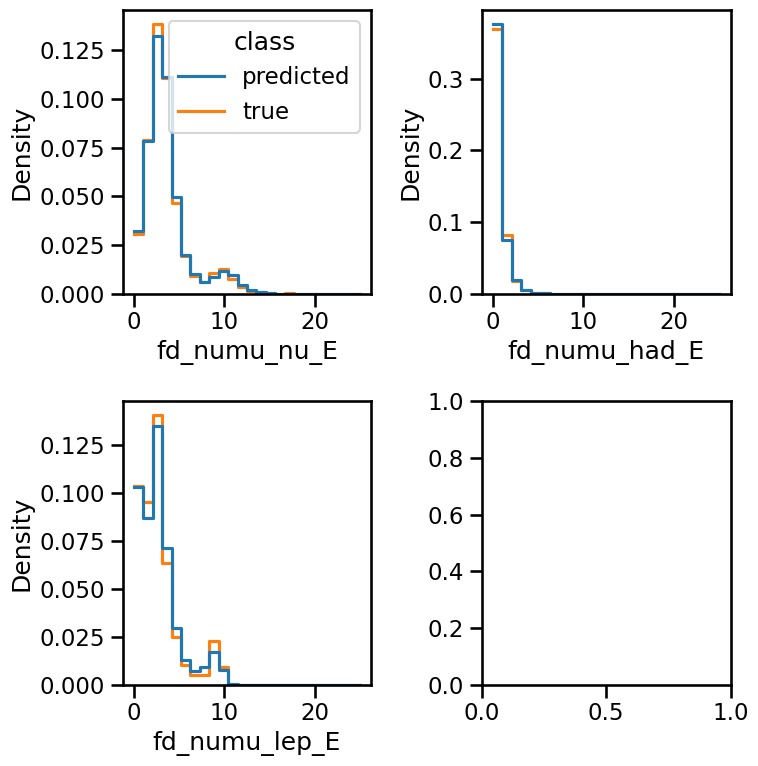

In [35]:
bins = np.linspace(0, 25, 25)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

common_kwargs = dict(hue='class', stat='density', element='step', common_norm=True, bins=bins, fill=False)

sns.histplot(data=df, x='fd_numu_nu_E', ax=ax[0, 0], **common_kwargs, legend=True)
sns.histplot(data=df, x='fd_numu_had_E', ax=ax[0, 1], **common_kwargs, legend=False)
sns.histplot(data=df, x='fd_numu_lep_E', ax=ax[1, 0], **common_kwargs, legend=False)

plt.tight_layout()

Text(0.5, 1.0, 'true')

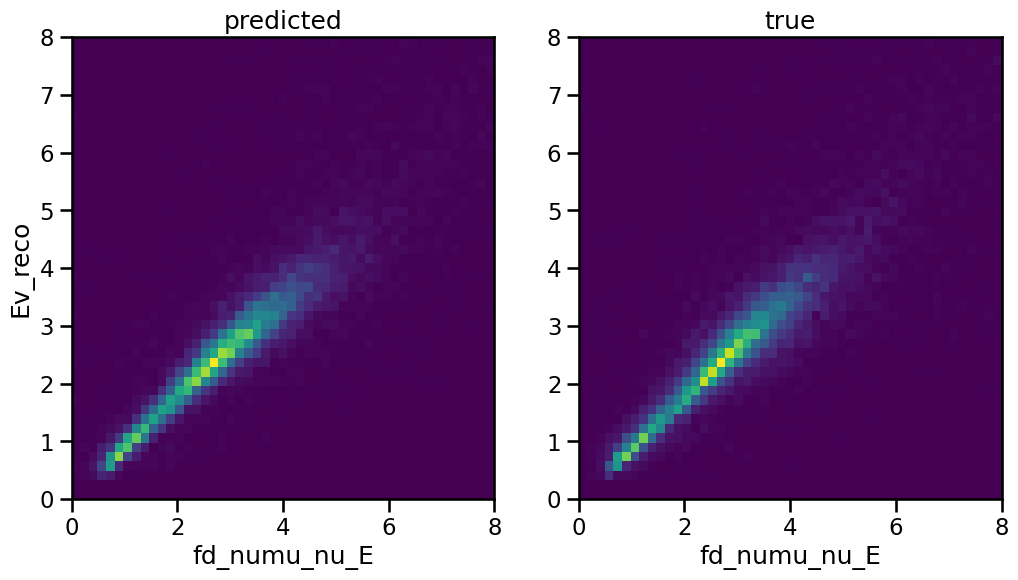

In [36]:
sns.set_context('talk')
def by_name(name, x):
    """Select column by name"""
    index = df.columns.get_loc(name)
    return x[:, index]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

y_col = 'Ev_reco' #'eRecoP', 'eRecoN', 'eRecoPip', 'eRecoPim', 'eRecoPi0', 'eRecoOther', 'Ev_reco', 'Elep_reco', 'theta_reco'            
x_col = 'fd_numu_nu_E' # 'numu_lep_E', 'numu_had_E', 'numu_nu_E', 'nue_lep_E', 'nue_had_E', 'nue_nu_E'
x = by_name(x_col, pred)
y = by_name(y_col, pred)
bins_y = np.linspace(0, 8.0, 50)
bins_x = np.linspace(0, 8, 50)
ax[0].hist2d(x, y, bins=(bins_x, bins_y), cmin=0)
ax[0].set_xlabel(x_col)
ax[0].set_ylabel(y_col)
ax[0].set_title('predicted')

true = test_dataset.data[:batch_size*num_iter]
x = by_name(x_col, true)
y = by_name(y_col, true)
ax[1].hist2d(x, y, bins=(bins_x, bins_y), cmin=0)
ax[1].set_xlabel(x_col)
ax[1].set_title('true')